# Assignment: Shock-tube

### Load Modules

In [354]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

from matplotlib import animation
from JSAnimation.IPython_display import display_animation

### Setup parameters

In [355]:
# Construct grid
nx = 81
dx = 0.25
dt = 0.0002
T = 0.01
nt = int(T/dt)
gamma = 1.4
x_L = -10
x_R = 10

### Initial Condition

In [356]:
#Boundary conditions LEFT
rho_L = 1.
vel_L = 0.
pressure_L = 100.

#Boundary conditions RIGHT
rho_R = 0.125
vel_R = 0.
pressure_R = 10.

x=numpy.linspace(x_L,x_R,nx)

# Density
rho0=numpy.zeros(nx)
rho0[0:int((nx-1)/2)]=rho_L
rho0[int((nx-1)/2):nx]=rho_R

# Velocity
vel0=numpy.zeros(nx)
vel0[0:int((nx-1)/2)]=vel_L
vel0[int((nx-1)/2):nx]=vel_R

# pressure
pressure0=numpy.zeros(nx)
pressure0[0:int((nx-1)/2)]=pressure_L
pressure0[int((nx-1)/2):nx]=pressure_R

# energy
energy = rho0 / (gamma-1)*rho0
energyT0=numpy.zeros(nx)
energyT0[0:int((nx-1)/2)]=energy[0:int((nx-1)/2)] + 0.5*vel_L
energyT0[int((nx-1)/2):nx]=energy[int((nx-1)/2):nx] + 0.5*vel_R


### Plot Initial Conditions

#### Density

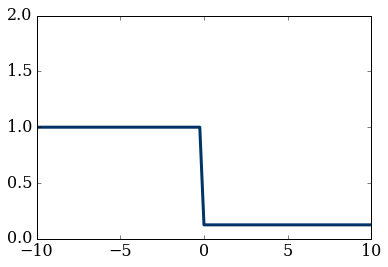

In [357]:
pyplot.plot(x, rho0, color='#003366', ls='-', lw=3)
pyplot.ylim(0.,2.);

#### Pressure

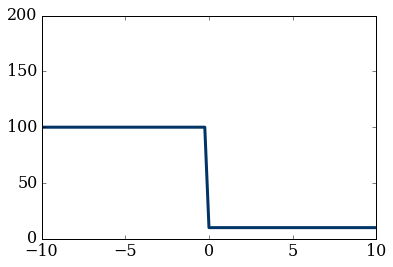

In [358]:
pyplot.plot(x, pressure0, color='#003366', ls='-', lw=3)
pyplot.ylim(0,200);

#### Velocity

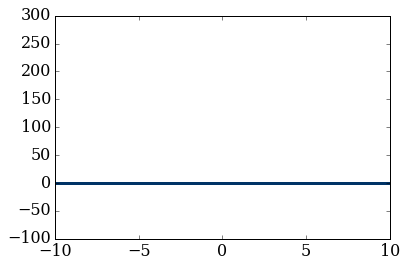

In [359]:
pyplot.plot(x, vel0, color='#003366', ls='-', lw=3)
pyplot.ylim(-100, 300);

#### Energy

(-0.2, 3)

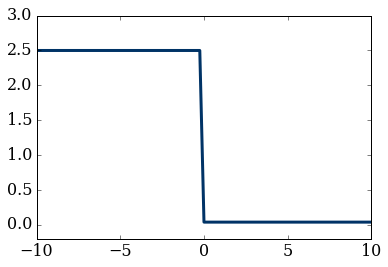

In [360]:
pyplot.plot(x, energyT0, color='#003366', ls='-', lw=3)
pyplot.ylim(-0.2, 3)

### Define a function f() to match the right-hand side of our equations

In [361]:
def f(U,gamma):
    """Returns the right-hand side of the rocket system of equations.
    
    Parameters
    ----------
    u : array of float
        array containing the solution at time n.
        
    Returns
    -------
    F : array of float
        array containing the RHS given u.
    """
    
    # Extract parameters from vector U
    u1 = U[0] # density
    u2 = U[1] # density * velocity
    u3 = U[2] # density * energyT
    u4 = U[3] # pressure
    
    return numpy.array([ u2,
                       u2**2/u1 + (gamma - 1) * (u3 - 0.5 * (u2**2 / u1)),
                       (u3 + (gamma - 1) * (u3 - 0.5 * u2**2 / u1)) * u2/u1,
                       (gamma - 1) * (u3 - 0.5 * u2**2 / u1)])  

### Richtmyer scheme

In [362]:
def richtmyer(rho, vel, pressure, energyT, nt, dt, dx, gamma):
    """ Computes the solution with forward in time, backward in space
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    vel    : array of floats
            Velocity at current time-step    
    press  : array of floats
             Pressure
    energy:  array of flaots
              Energy
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    gamma: float
            Constant
    
    Returns
    -------
    U : array of floats
            solution grid after nt time steps at every point x
    """
    
    #Initialise initial grid
    U=numpy.zeros((nt, 4, len(rho)))
    #print(U.shape)
    U[0, 0] = rho
    U[0, 1] = rho * vel
    U[0, 2] = rho * energyT
    U[0, 3] = pressure
    
    U=numpy.zeros((nt, 4, len(rho)))
    #print(U.shape)
    U[0, 0] = rho
    U[0, 1] = rho * vel
    U[0, 2] = rho * energyT
    U[0, 3] = pressure
    
    #initialize our results array with dimensions nt by nx
    U_n = numpy.zeros((nt, 4, len(rho))) 
    #copy the initial u array into each row of our new array
    U_n = U.copy()    
    U_star = numpy.empty_like(U[0])
    U_iter = numpy.empty_like(U[0])
    U_iter = U[0]
        
    for t in range (1,5):
        # Step 1
        #F1 = f(U[t-1], gamma)
        F = f(U_iter, gamma)
        
        #U_star[t,:,1:-1] = 0.5*(U[t,:,2:] + U[t,:,1:-1]) - dt/2*dx * (F1[:,2:] - F1[:,1:-1])
        
        U_star[:,1:-1] = 0.5*(U_iter[:,2:] + U_iter[:,1:-1]) - dt/2*dx * (F[:,2:]-F[:,1:-1])
        U_star[:,-1] = U_iter[:, -1]
        U_star[:,0] = U_iter[:, 0]
        
        # Step 2
        F2 = f(U_star, gamma)

        
        U_n[t,:,1:-1] = U_iter[:,1:-1] - dt/dx * (F2[:,2:] - F2[:,1:-1])
        
        U_n[t,:,0] = U_iter[:,0]
        U_iter = U_n[t].copy()
    
    
    return U_n

### MacCormack

In [363]:
def maccormack(rho, vel, pressure, energyT, nt, dt, dx, gamma):
    """ Computes the solution with MacCormack scheme
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    vel    : array of floats
            Velocity at current time-step    
    press  : array of floats
             Pressure
    energy:  array of flaots
              Energy
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    gamma: float
            Constant
    
    Returns
    -------
    U : array of floats
            solution grid after nt time steps at every point x
    """
    
    
    U=numpy.zeros((nt, 4, len(rho)))
    #print(U.shape)
    U[0, 0] = rho
    U[0, 1] = rho * vel
    U[0, 2] = rho * energyT
    U[0, 3] = pressure
    
    #initialize our results array with dimensions nt by nx
    U_n = numpy.zeros((nt, 4, len(rho))) 
    #copy the initial u array into each row of our new array
    U_n = U.copy()    
    U_star = numpy.empty_like(U[0])
    U_iter = numpy.empty_like(U[0])
    U_iter = U[0]
    """
    for t in range(1,nt):
        #F = computeF(u_max, rho, aval, bval)
        F = f(U[t-1], gamma)
        rho_star[:-1] = rho[:-1] - dt/dx * (F[1:]-F[:-1])
        Fstar = computeF(u_max, rho_star, aval, bval)
        rho_n[t,1:] = .5 * (rho[1:]+rho_star[1:] - dt/dx * (Fstar[1:] - Fstar[:-1]))
        rho = rho_n[t].copy()
    """    
    for t in range(1,nt):
        F = f(U_iter, gamma)
        #print('t = ', t)
        #print('F[0]', F[0])
        #print('F[1]', F[1])
        #print('F[2]', F[2])
        #print('F[3]', F[3])
        #print('U[t,:,:-1].shape', U[t,:,:-1].shape)
        #print('F[:,1:].shape', F[:,1:].shape)
        #print('F[:,:-1].shape', F[:,:-1].shape)
        U_star[:,:-1] = U_iter[:,:-1] - dt/dx * (F[:,1:]-F[:,:-1])
        U_star[:,-1] = U_iter[:, -1]
        #print('U_star[0]', U_star[0])
        Fstar = f(U_star, gamma)
        U_n[t,:,1:] = .5 * (U_iter[:,1:]+U_star[:,1:] - dt/dx * (Fstar[:,1:] - Fstar[:,:-1]))
        U_n[t,:,0] = U_iter[:,0]
        #print('U_n[t, 0]', U_n[t,0])
        U_iter = U_n[t].copy()
        
    return U_n

### Simulation

In [364]:

# call Richtmyer scheme
U_rich = richtmyer(rho0, vel0, pressure0, energy0, nt, dt, dx, gamma)
U = maccormack(rho0, vel0, pressure0, energyT0, nt, dt, dx, gamma)


# Retrieve variables
rho=U[:,0]
vel=U[:,1]/rho
pressure = U[:, 3]
pressure[20]




/home/gavin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/gavin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/gavin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in true_divide


array([ 100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.0000001 ,  100.0000001 ,  100.00798433,
         10.00798433,    9.99999988,   10.        ,   10.        ,
         10.        ,   10.        ,   10.        ,   10.        ,
         10.        ,   10.        ,   10.        ,   10.        ,
         10.        ,   10.        ,   10.        ,   10.        ,
         10.        ,   10.        ,   10.        ,   10.     

### Animations

#### Density


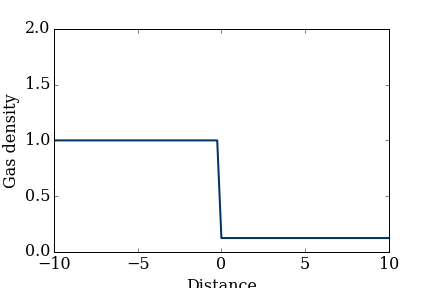
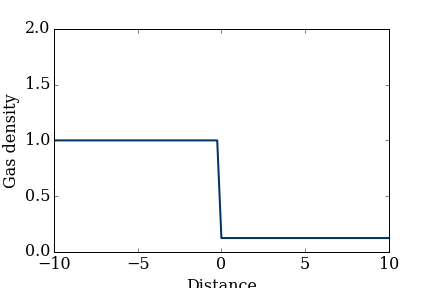
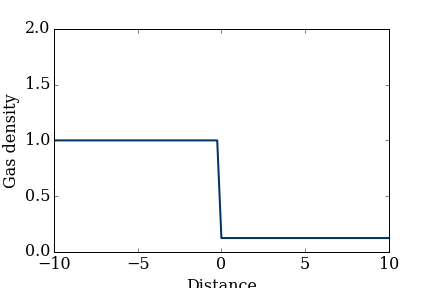
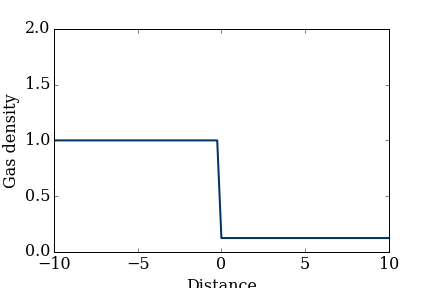
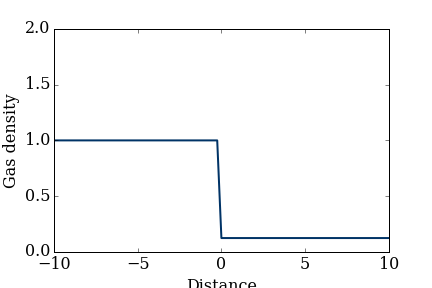
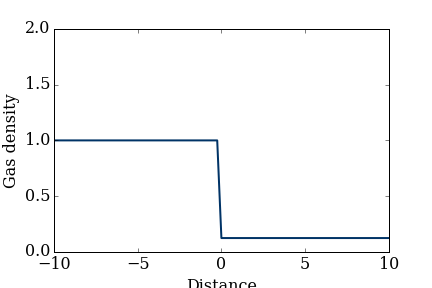
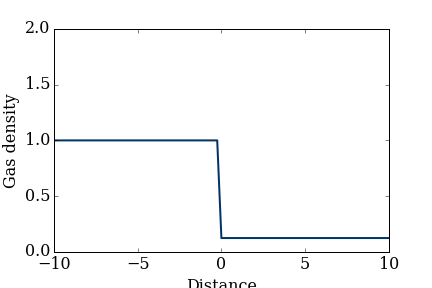
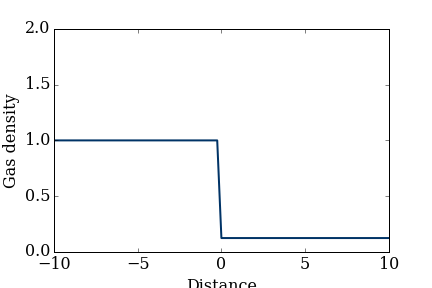
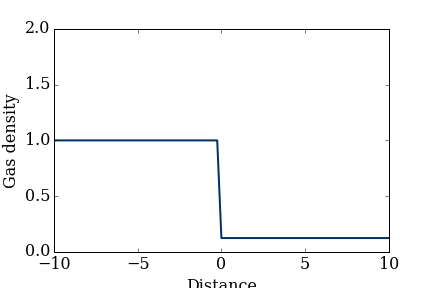
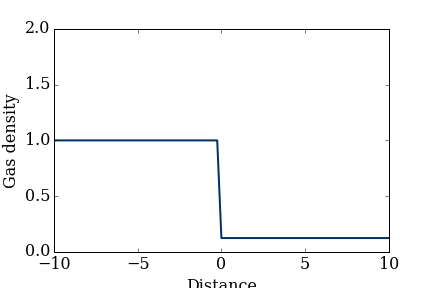
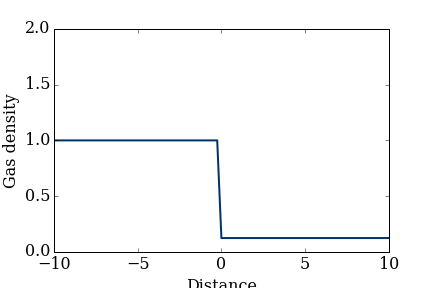
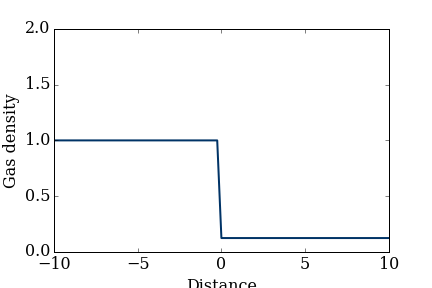
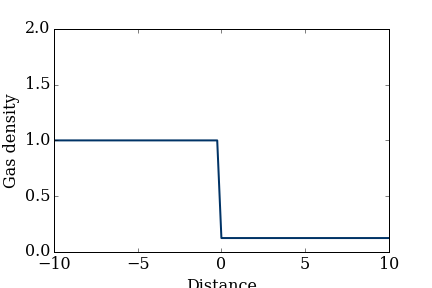
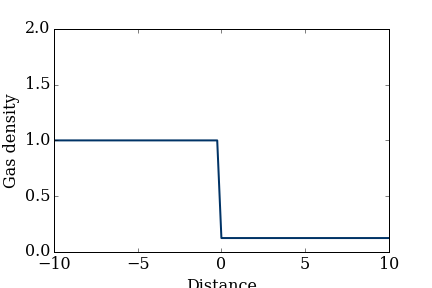
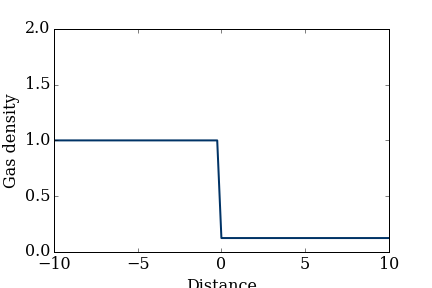
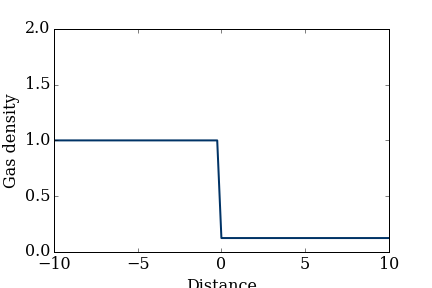
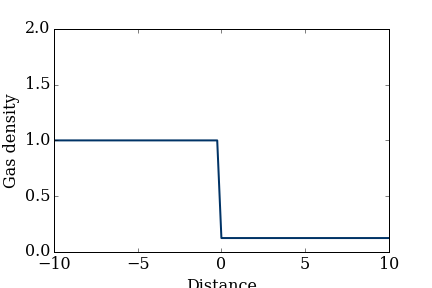
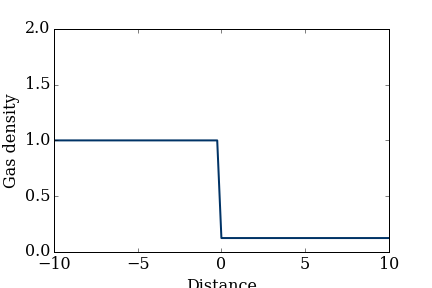
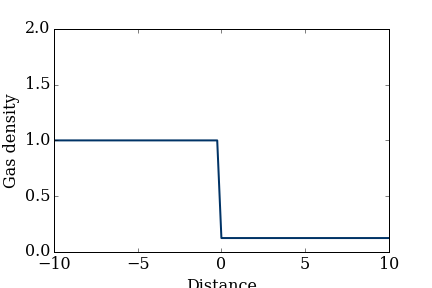
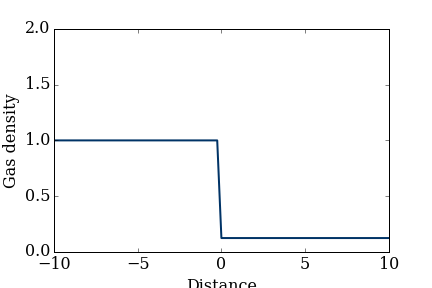
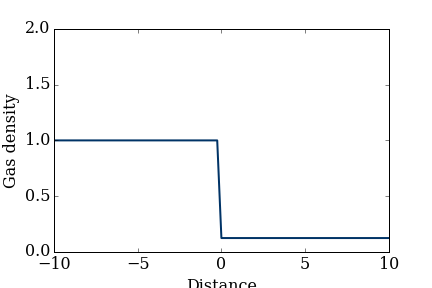
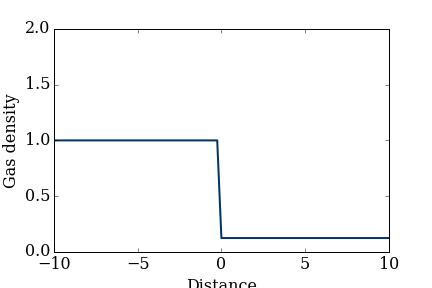
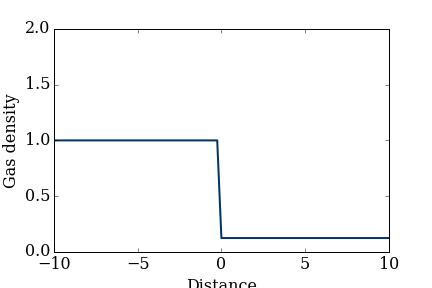
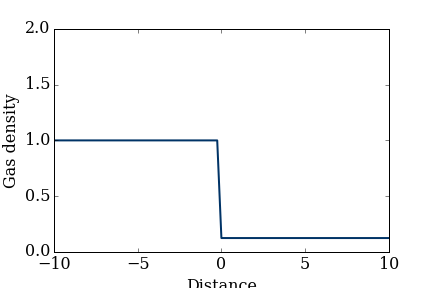
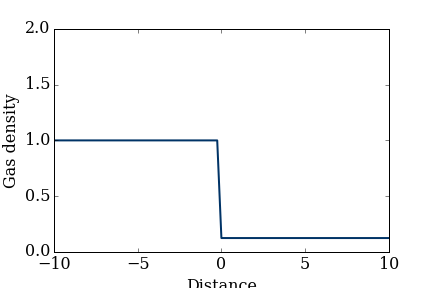
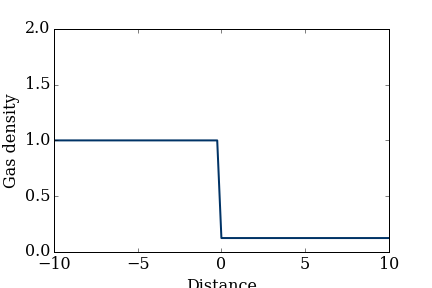
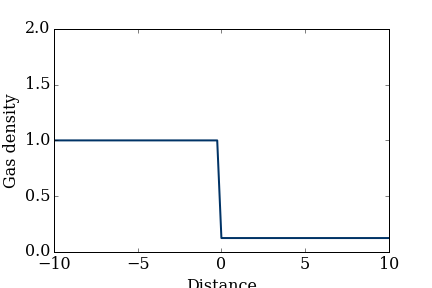
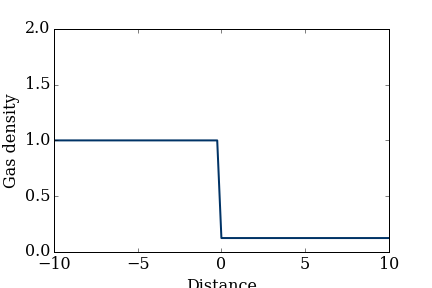
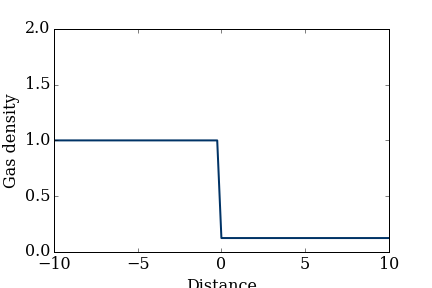
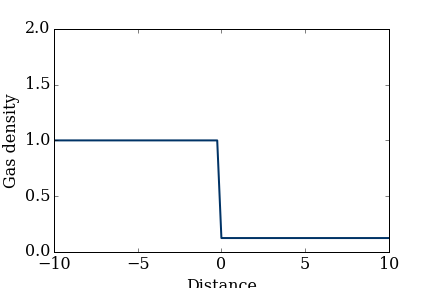
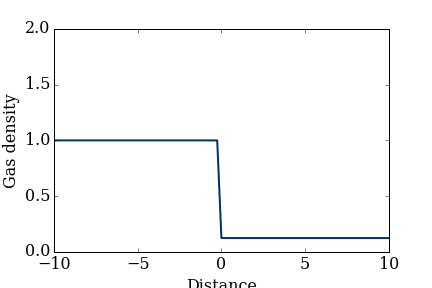
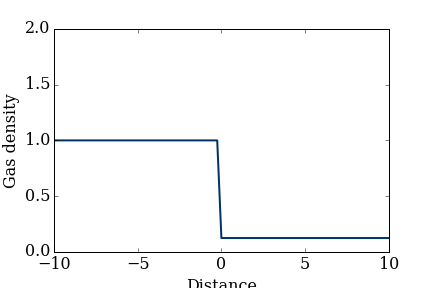
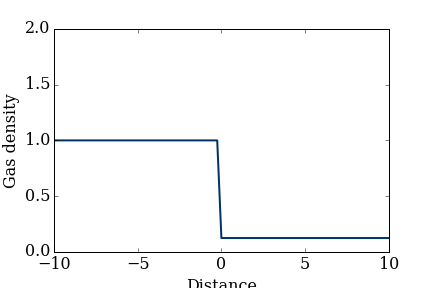
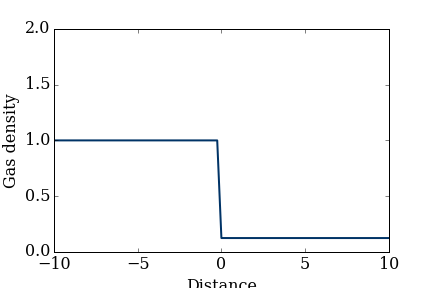
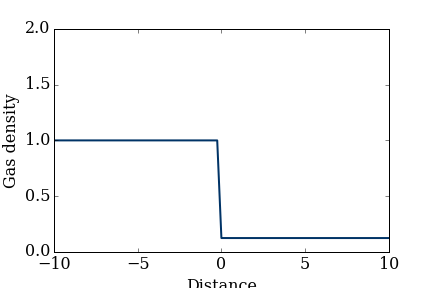
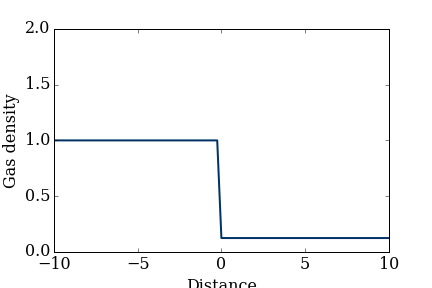
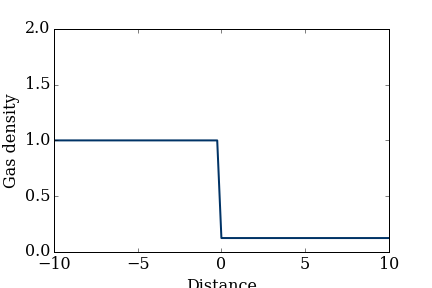
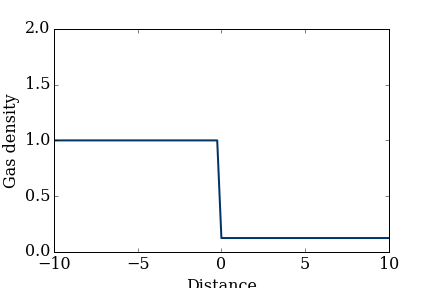
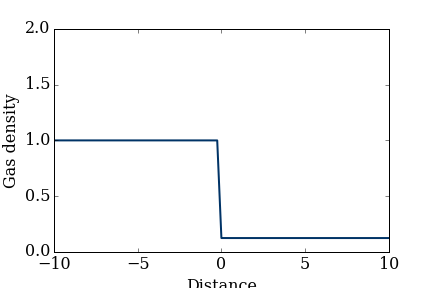
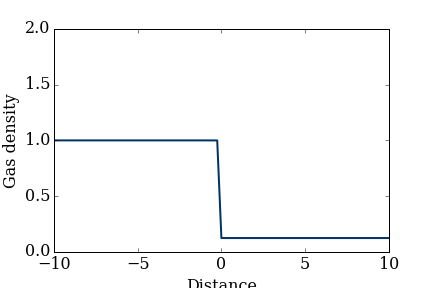
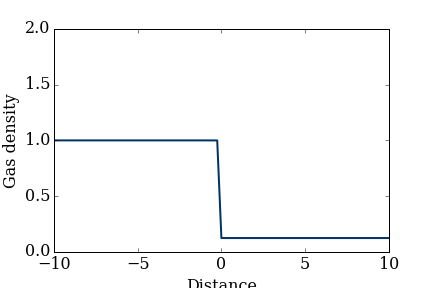
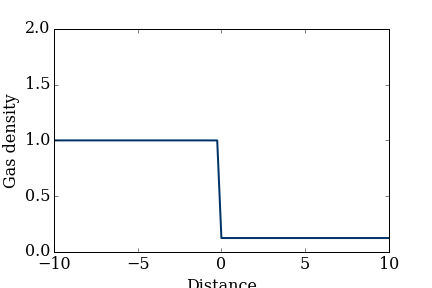
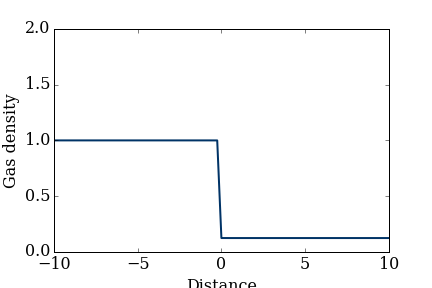
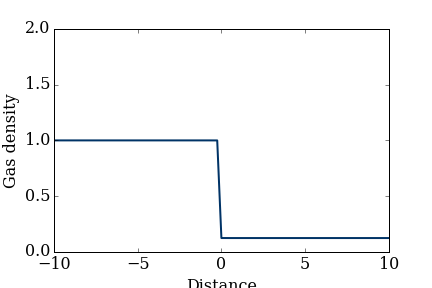
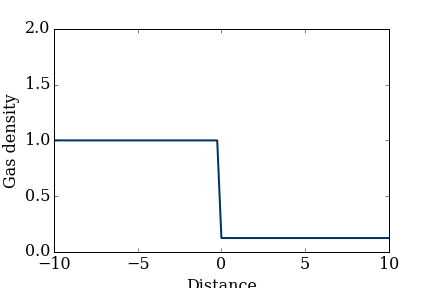
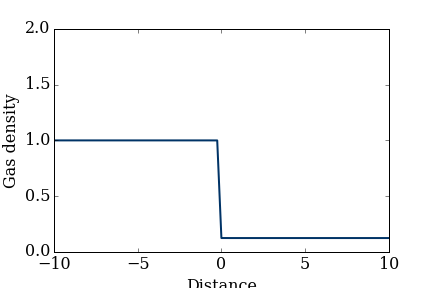
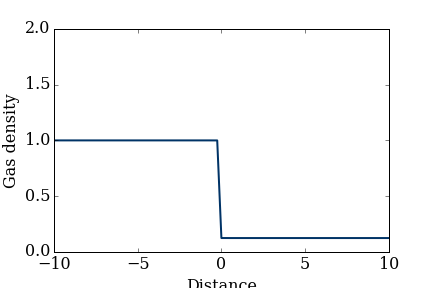
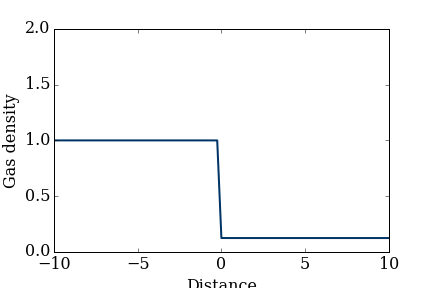
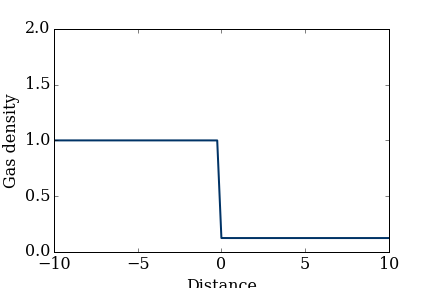
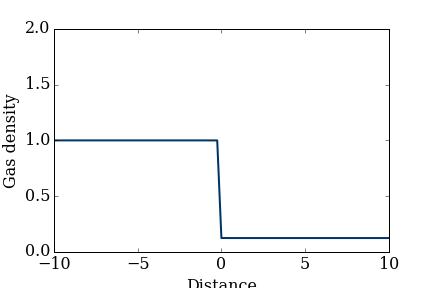

In [365]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(-10,10),ylim=(0, 2),xlabel=('Distance'),ylabel=('Gas density'));
line, = ax.plot([],[],color='#003366', lw=2);

def animate(data):
    x = numpy.linspace(x_L,x_R,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=rho, interval=50)
display_animation(anim, default_mode='once')

#### Velocity


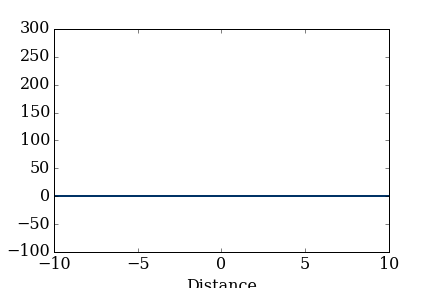
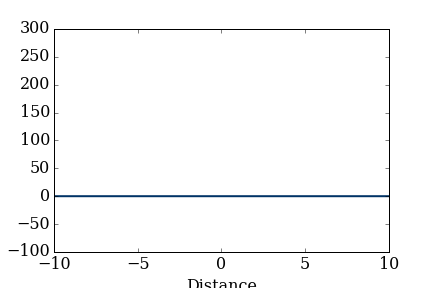
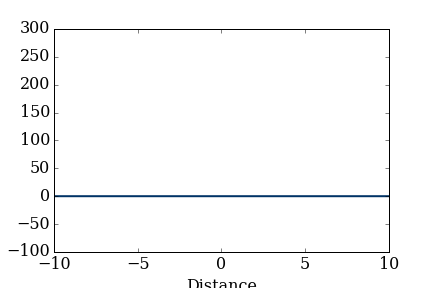
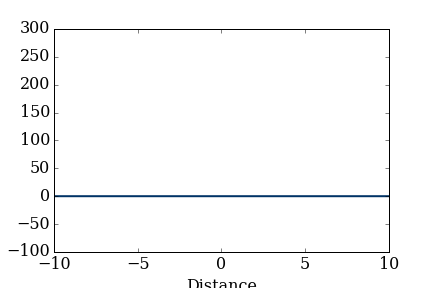
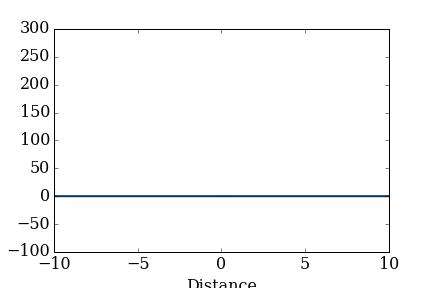
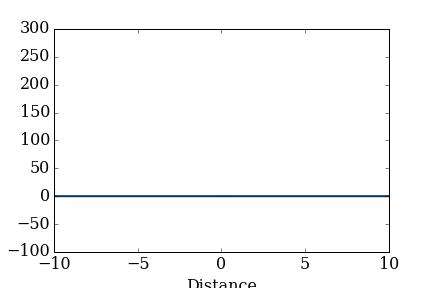
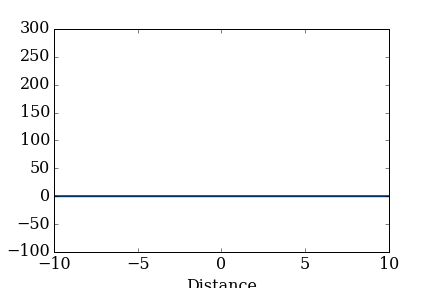
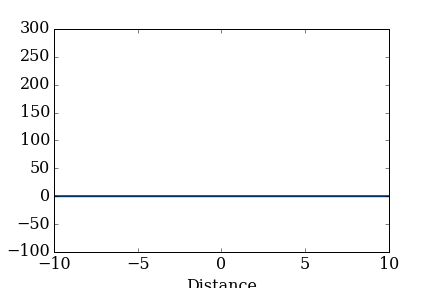
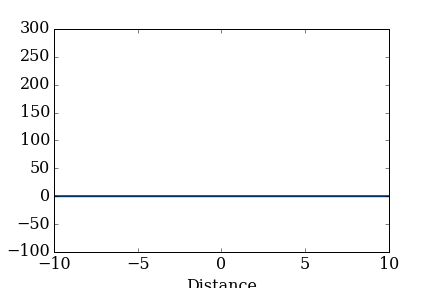
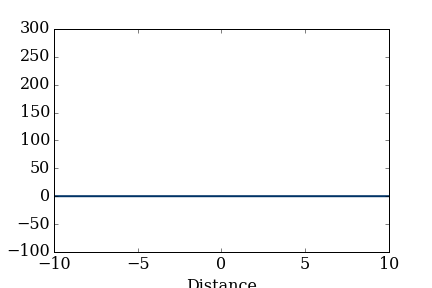
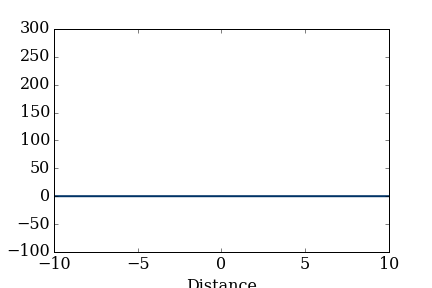
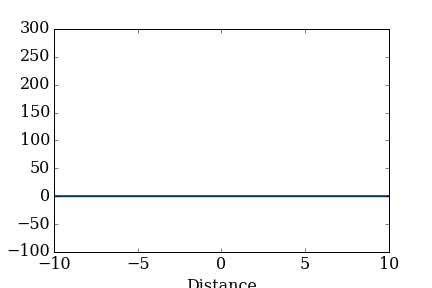
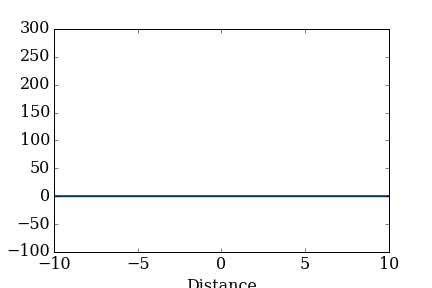
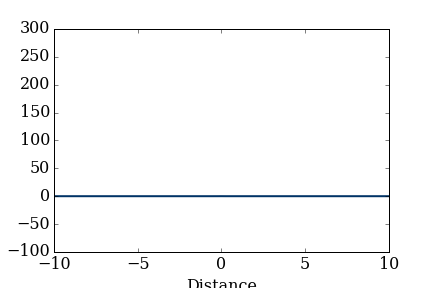
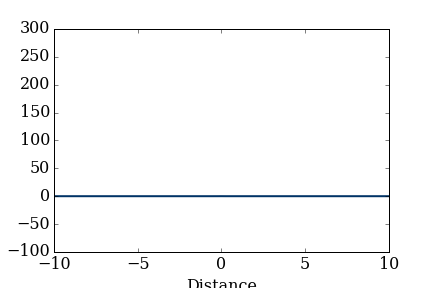
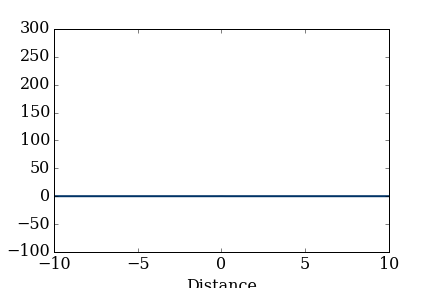
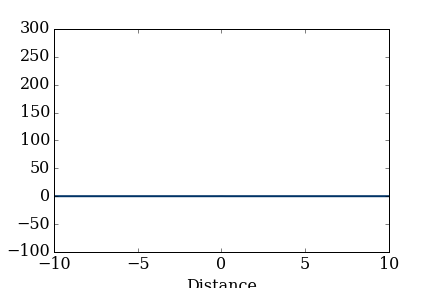
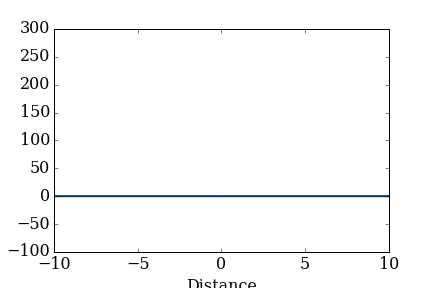
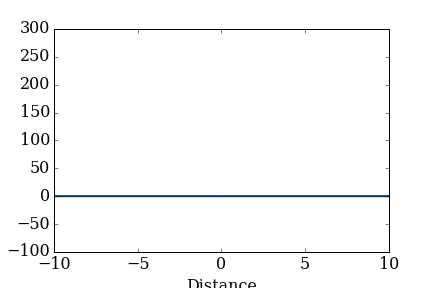
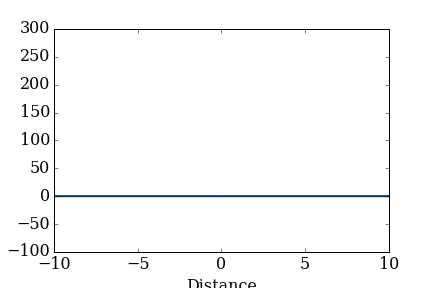
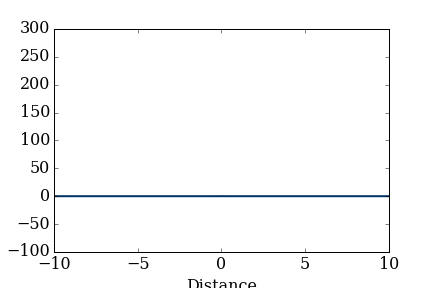
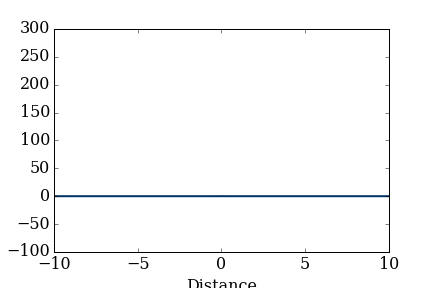
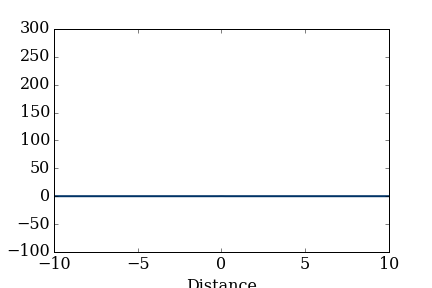
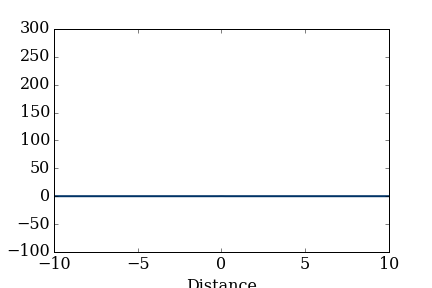
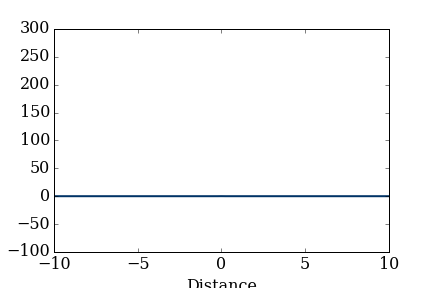
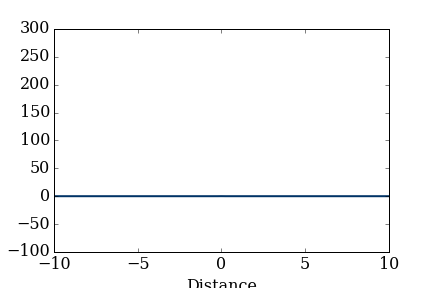
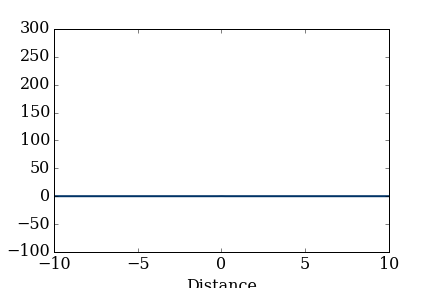
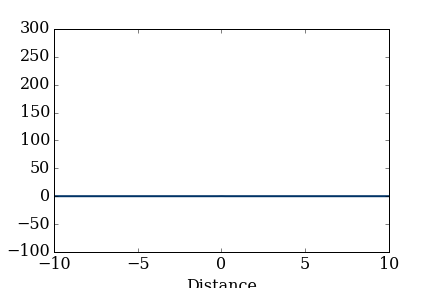
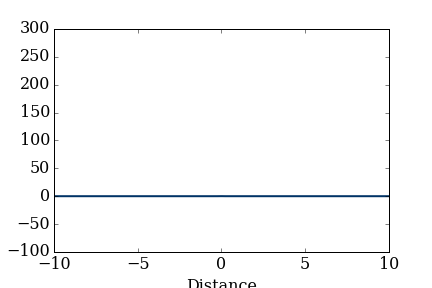
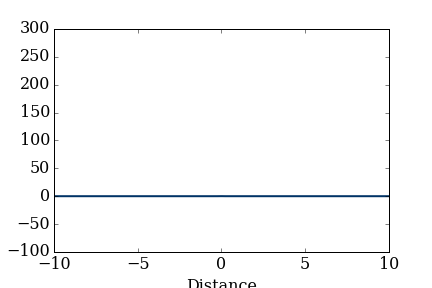
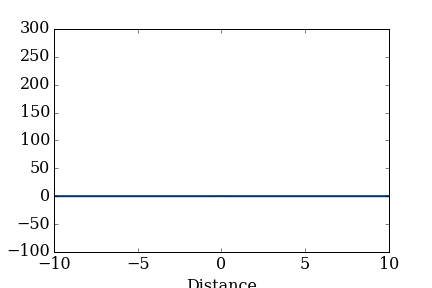
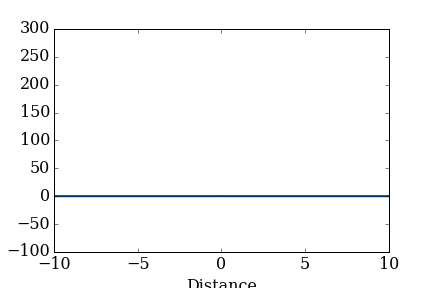
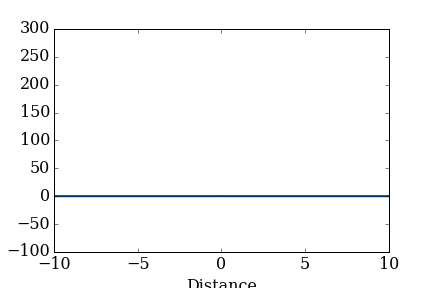
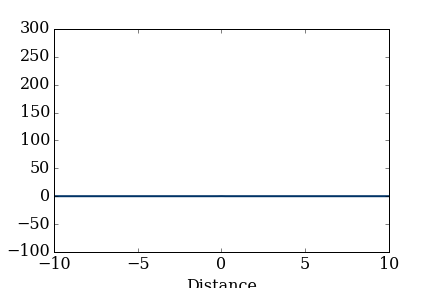
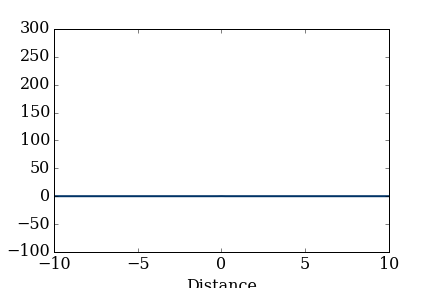
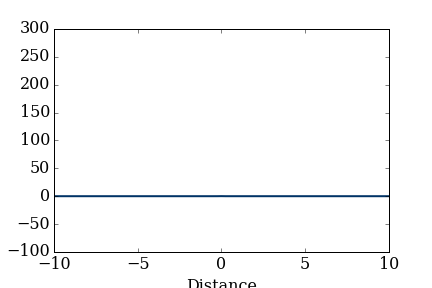
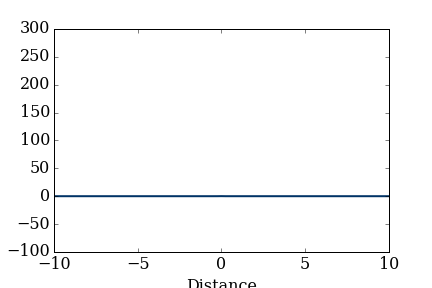
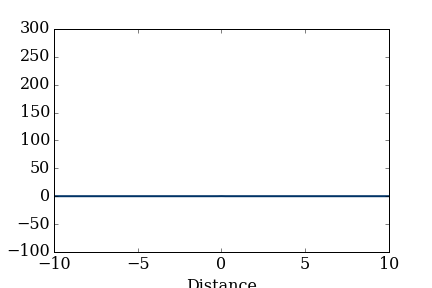
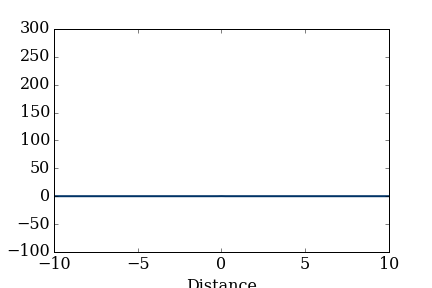
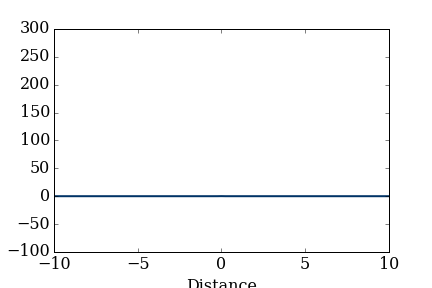
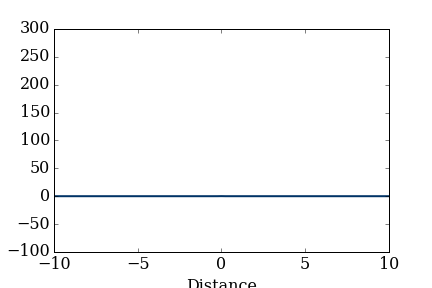
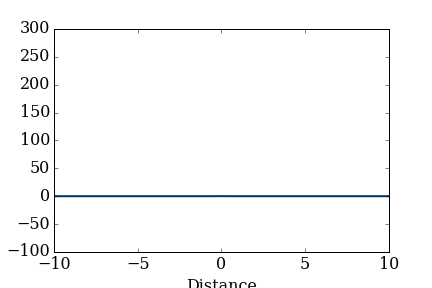
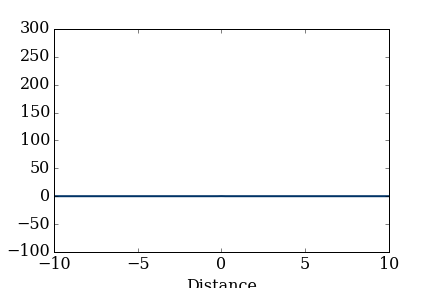
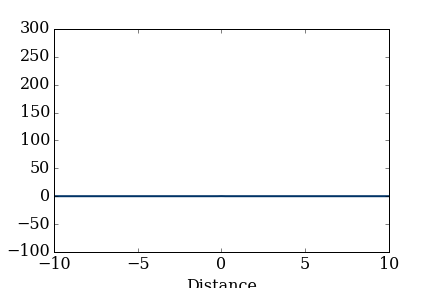
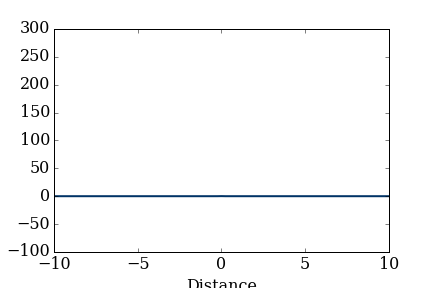
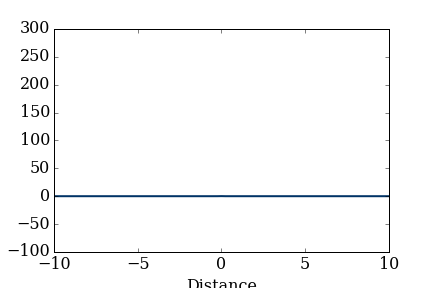
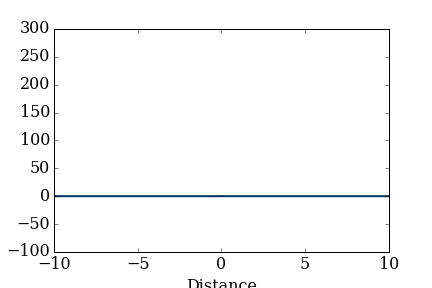
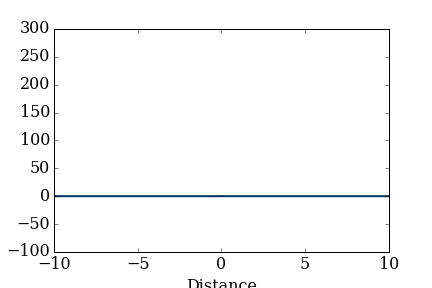
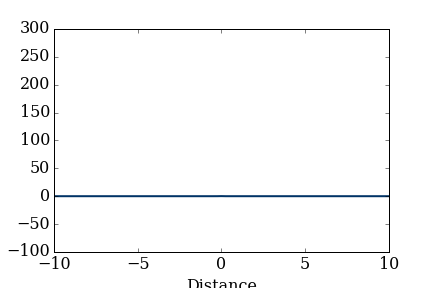
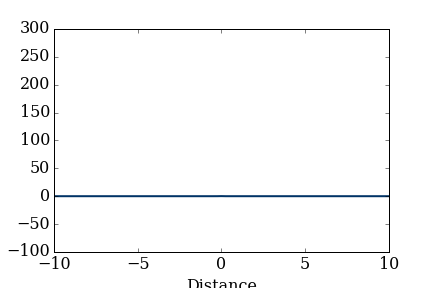

In [366]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(-10,10),ylim=(-100, 300),xlabel=('Distance'),ylabel=('Gas velocity'));
line, = ax.plot([],[],color='#003366', lw=2);

def animate(data):
    x = numpy.linspace(x_L,x_R,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=vel, interval=50)
display_animation(anim, default_mode='once')

#### Pressure


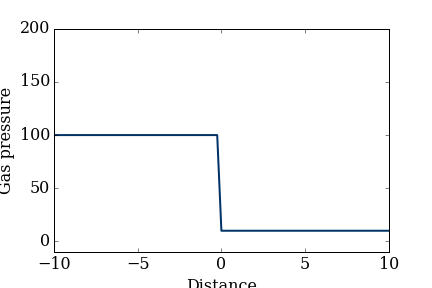
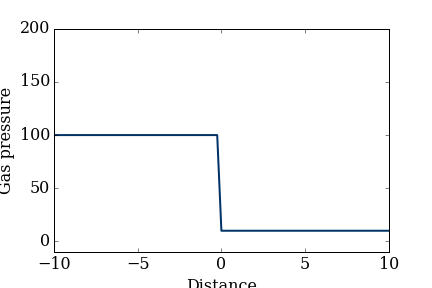
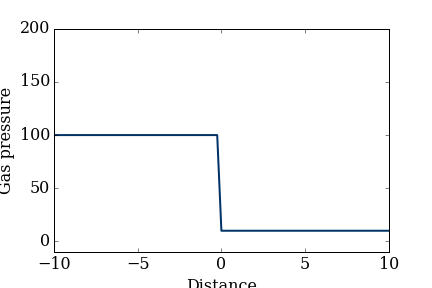
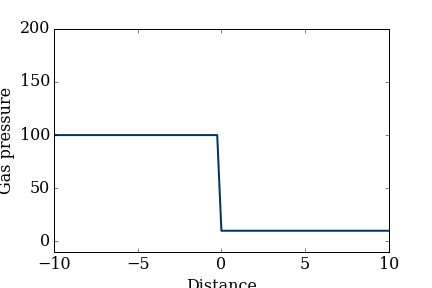
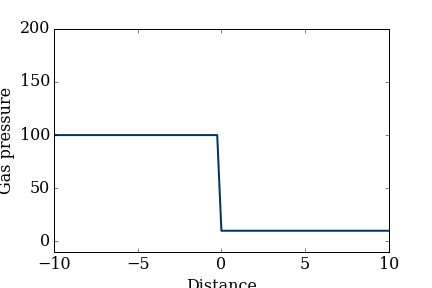
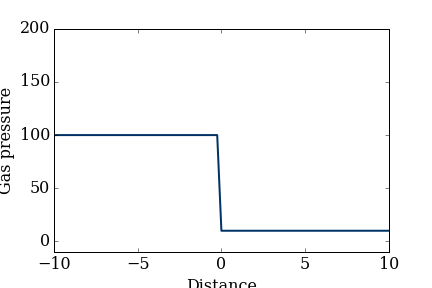
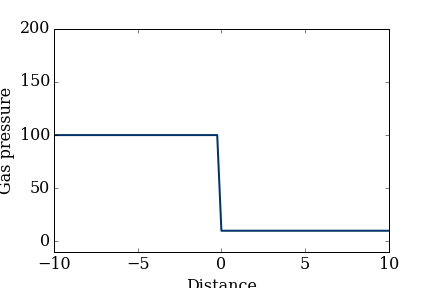
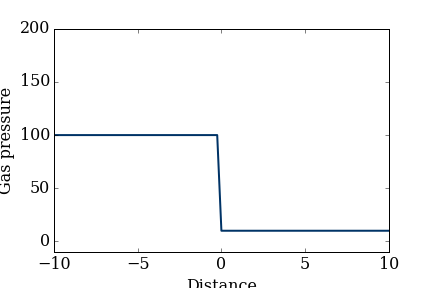
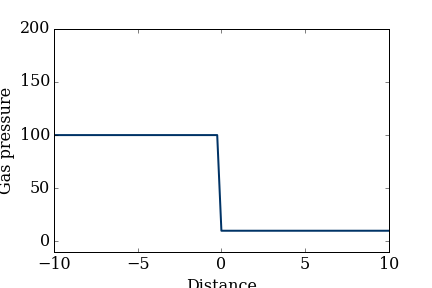
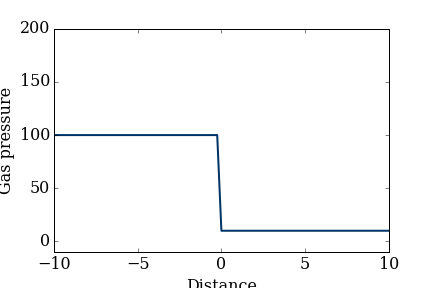
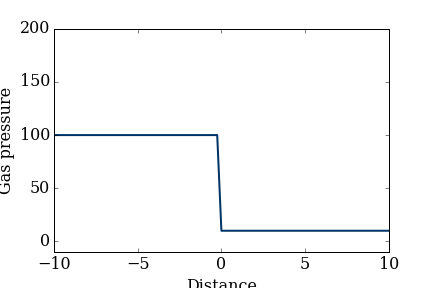
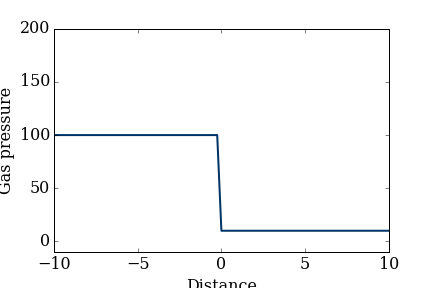
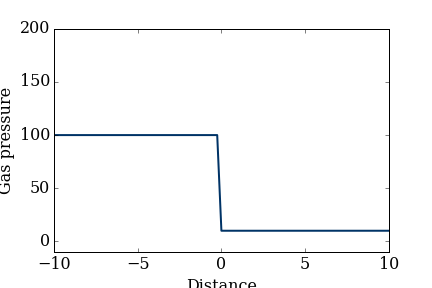
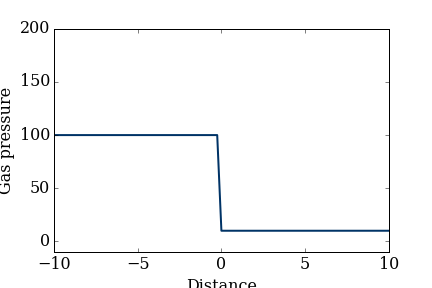
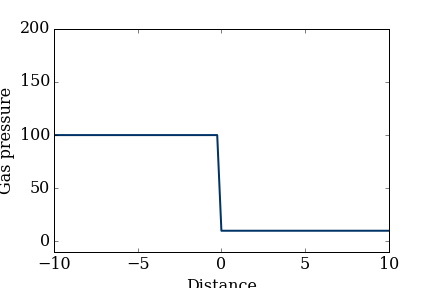
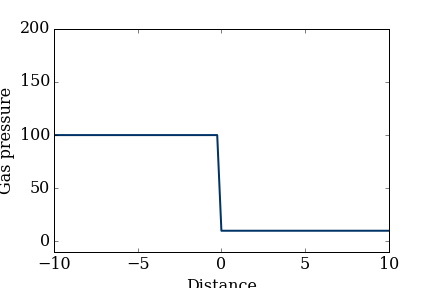
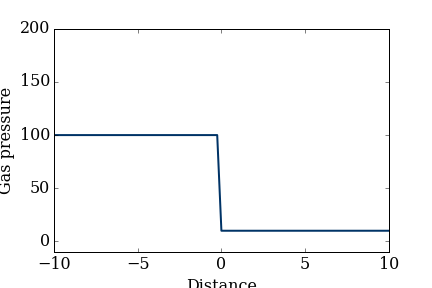
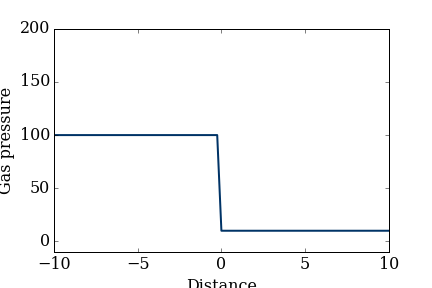
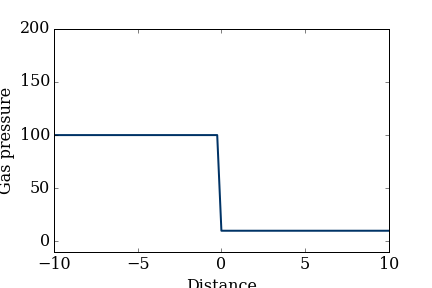
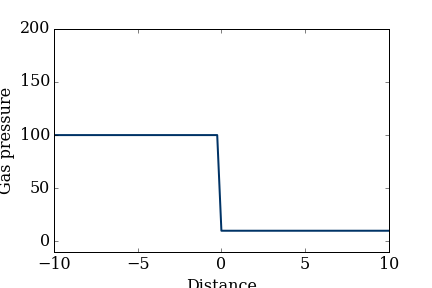
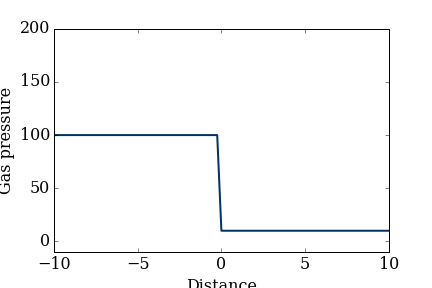
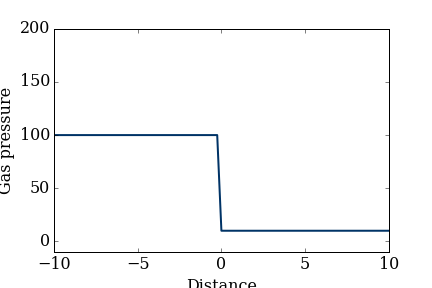
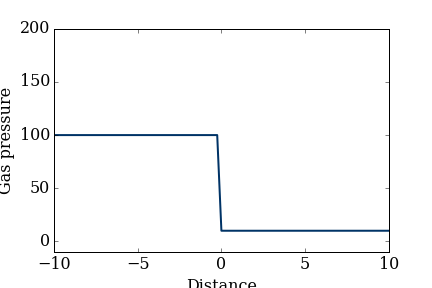
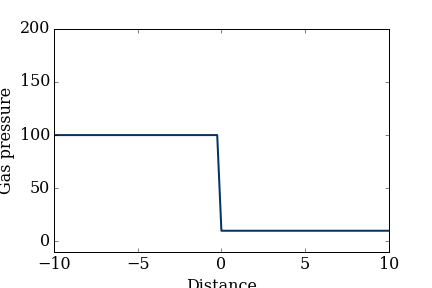
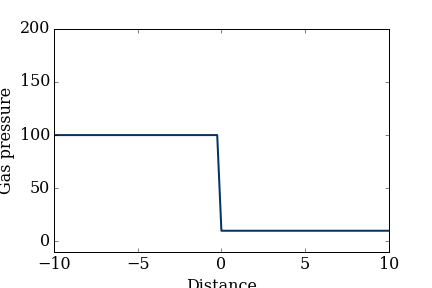
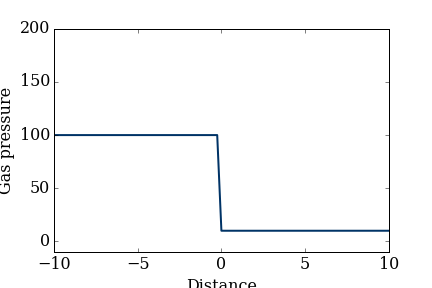
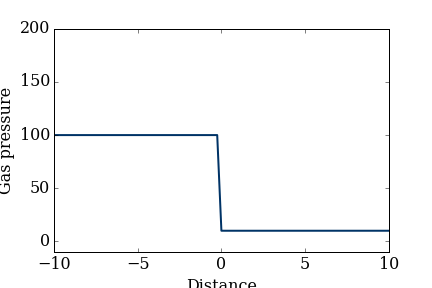
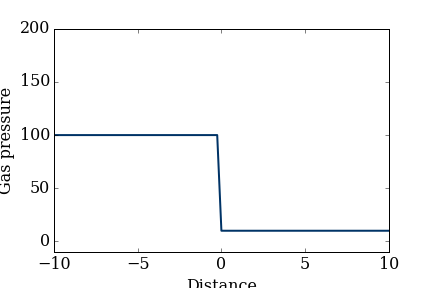
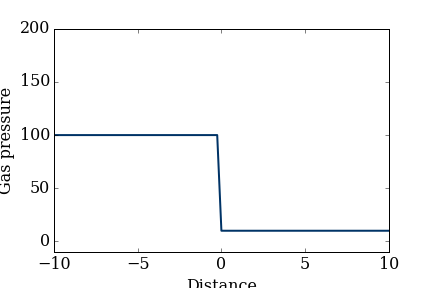
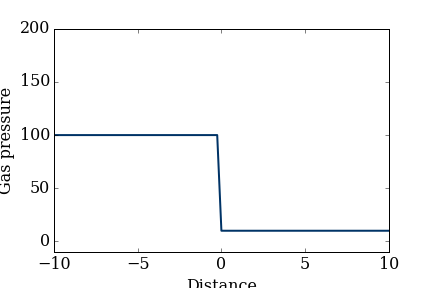
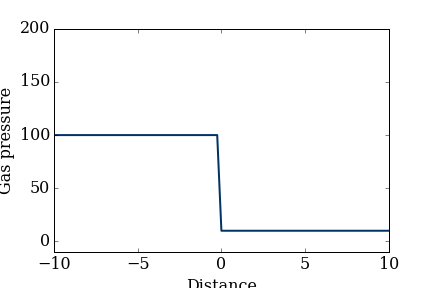
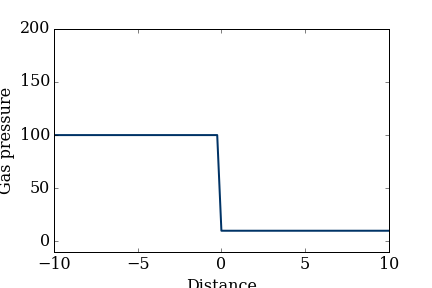
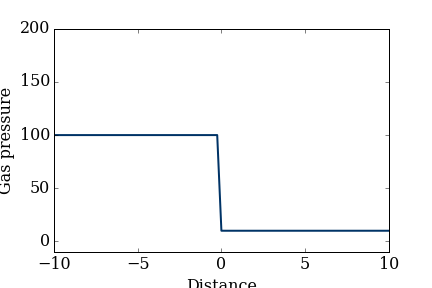
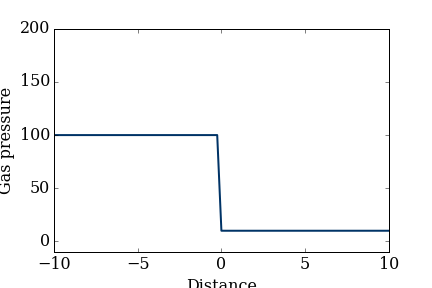
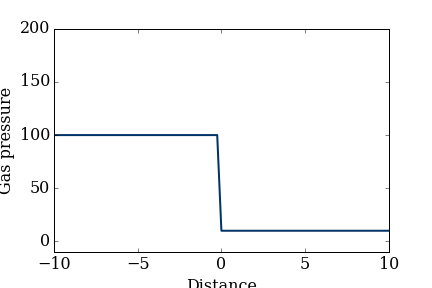
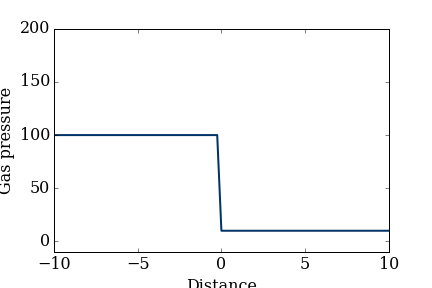
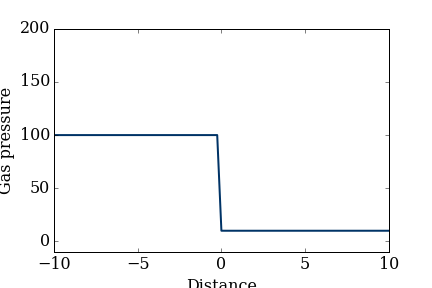
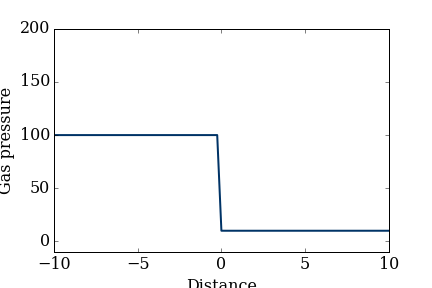
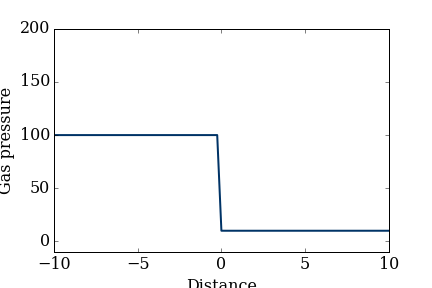
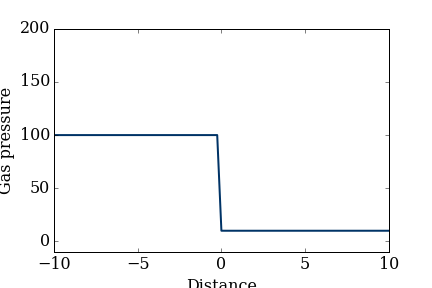
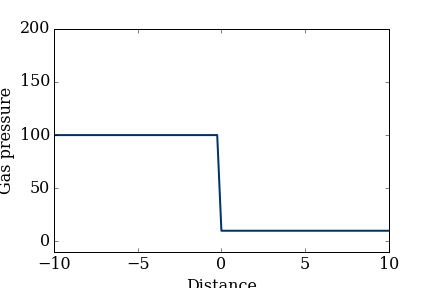
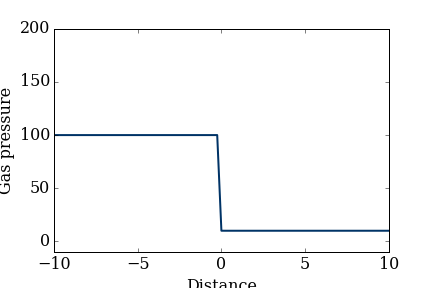
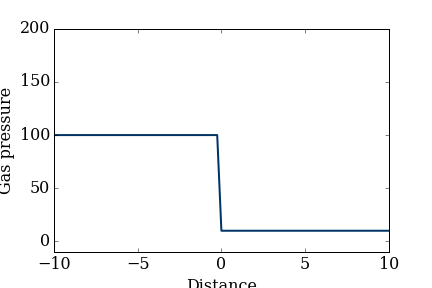
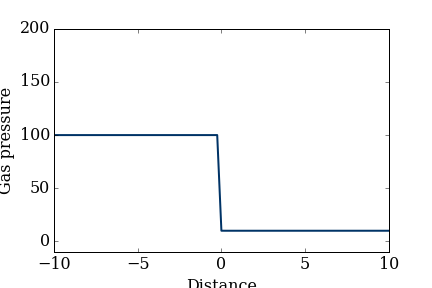
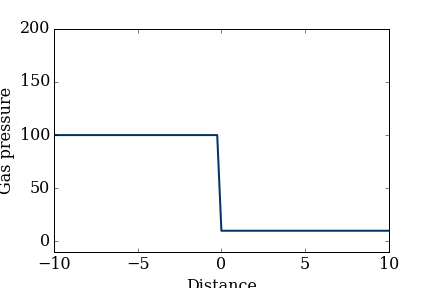
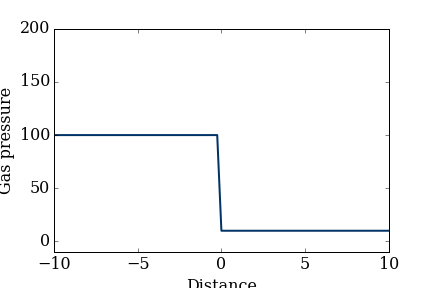
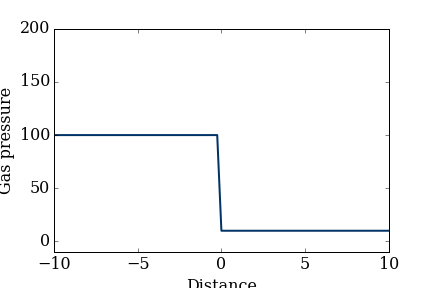
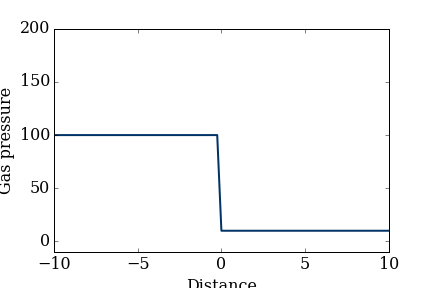
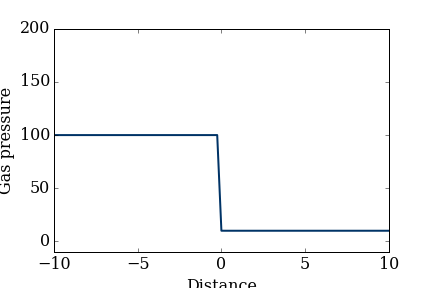
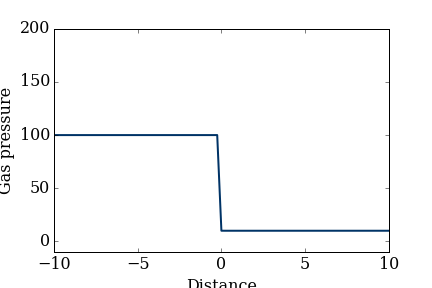

In [367]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(-10,10),ylim=(-10, 200),xlabel=('Distance'),ylabel=('Gas pressure'));
line, = ax.plot([],[],color='#003366', lw=2);

def animate(data):
    x = numpy.linspace(x_L,x_R,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=pressure, interval=50)
display_animation(anim, default_mode='once')